# intro

The goal of this will be to replicate Ben Barton figure 2 (he used the climatology for DJF, MAM, JJA, SON for 2005--2016)

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
mskBarents = mskBasin[mskBasin == 6]

In [5]:
# also plot underneath this the average profiles
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

In [6]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [7]:
# get the theta and salt for all years

all_SST = np.full((len(allyears),12,ny,nx),np.nan)

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [8]:
all_SIarea = np.full((len(allyears),12,ny,nx),np.nan)


iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    thisyear_SIarea = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg2d_snap_set1'
        meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg2d_snap_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        SIareai,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SIarea[i,:,:] = np.reshape(SIareai,(ny,nx)) # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SIarea[iy,:,:,:] = thisyear_SIarea
    
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# do the plots

In [9]:
DXG = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0]
DYG = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0]

In [11]:
allyears[2:-1]

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [ ]:
# # Define output directory
# output_dir = "figs/PF_anim_DJFM/"

# # Define DJFM indices (December=11, January=0, February=1, March=2)
# djfm_indices = [11, 0, 1, 2]

# # Loop through each year
# for year_idx in range(len(allyears)):
#     year = allyears[year_idx]  # Extract actual year

#     # Select only DJFM months and compute mean
#     SST_DJFM = np.nanmean(all_SST[year_idx, djfm_indices], axis=0)  # Average SST over DJFM
#     SIarea_DJFM = np.nanmean(all_SIarea[year_idx, djfm_indices], axis=0)  # Average sea ice area

#     # Compute SST gradient (grad_T)
#     tracerSST = get_aste_tracer(SST_DJFM, nfx, nfy)[0]
#     dTdx = np.zeros_like(tracerSST)
#     dTdx[:, 1:-1] = (tracerSST[:, 2:] - tracerSST[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])

#     dTdy = np.zeros_like(tracerSST)
#     dTdy[1:-1, :] = (tracerSST[2:, :] - tracerSST[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])

#     grad_T = np.sqrt(dTdx**2 + dTdy**2)  # Compute  magnitude
#     mask = (tracerSST > -2) & (tracerSST < 4)  # Mask only within PF-relevant SST range
#     grad_T_masked = grad_T * mask * 1000  # Convert to °C/km

#     # Create figure
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#     # **Panel 1: SST Gradient + Land + Ice Edge**
#     ax = axes[0]
#     cb = ax.pcolormesh(grad_T_masked, cmap='nipy_spectral', vmin=0, vmax=0.1)  # Adjust vmax as needed
#     ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys")
#     cs = ax.contour(get_aste_tracer(SIarea_DJFM, nfx, nfy)[0], levels=[0.15], colors="white", linewidths=3)  # Ice edge contour (15%)
#     plt.colorbar(cb, ax=ax, label="SST Gradient (°C/km)")
#     ax.set_xlim(400, 540)
#     ax.set_ylim(420, 575)
#     ax.set_title(f"DJFM SST Gradient - {year}")

#     # **Panel 2: SST + Land + Ice Edge**
#     ax = axes[1]
#     cb = ax.pcolormesh(get_aste_tracer(SST_DJFM, nfx, nfy)[0], vmin=-2, vmax=4, cmap="coolwarm")
#     ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys")
#     cs = ax.contour(get_aste_tracer(SIarea_DJFM, nfx, nfy)[0], levels=[0.15], colors="white", linewidths=3)  # Ice edge contour (15%)
#     plt.colorbar(cb, ax=ax, label="SST (°C)")
#     ax.set_xlim(400, 540)
#     ax.set_ylim(420, 575)
#     ax.set_title(f"DJFM SST - {year}")

#     # **Save the figure with proper naming convention**
#     save_path = os.path.join(output_dir, f"SST_PF_DJFM_{year}.png")
#     plt.savefig(save_path, dpi=300, bbox_inches="tight")
#     plt.close(fig)  # Close figure to avoid memory leaks

#     print(f"Saved: {save_path}")

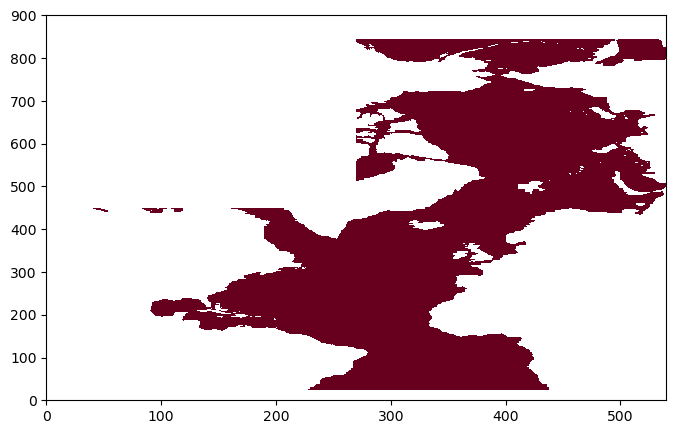

In [13]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [23]:
all_SST.shape

(15, 12, 1350, 270)

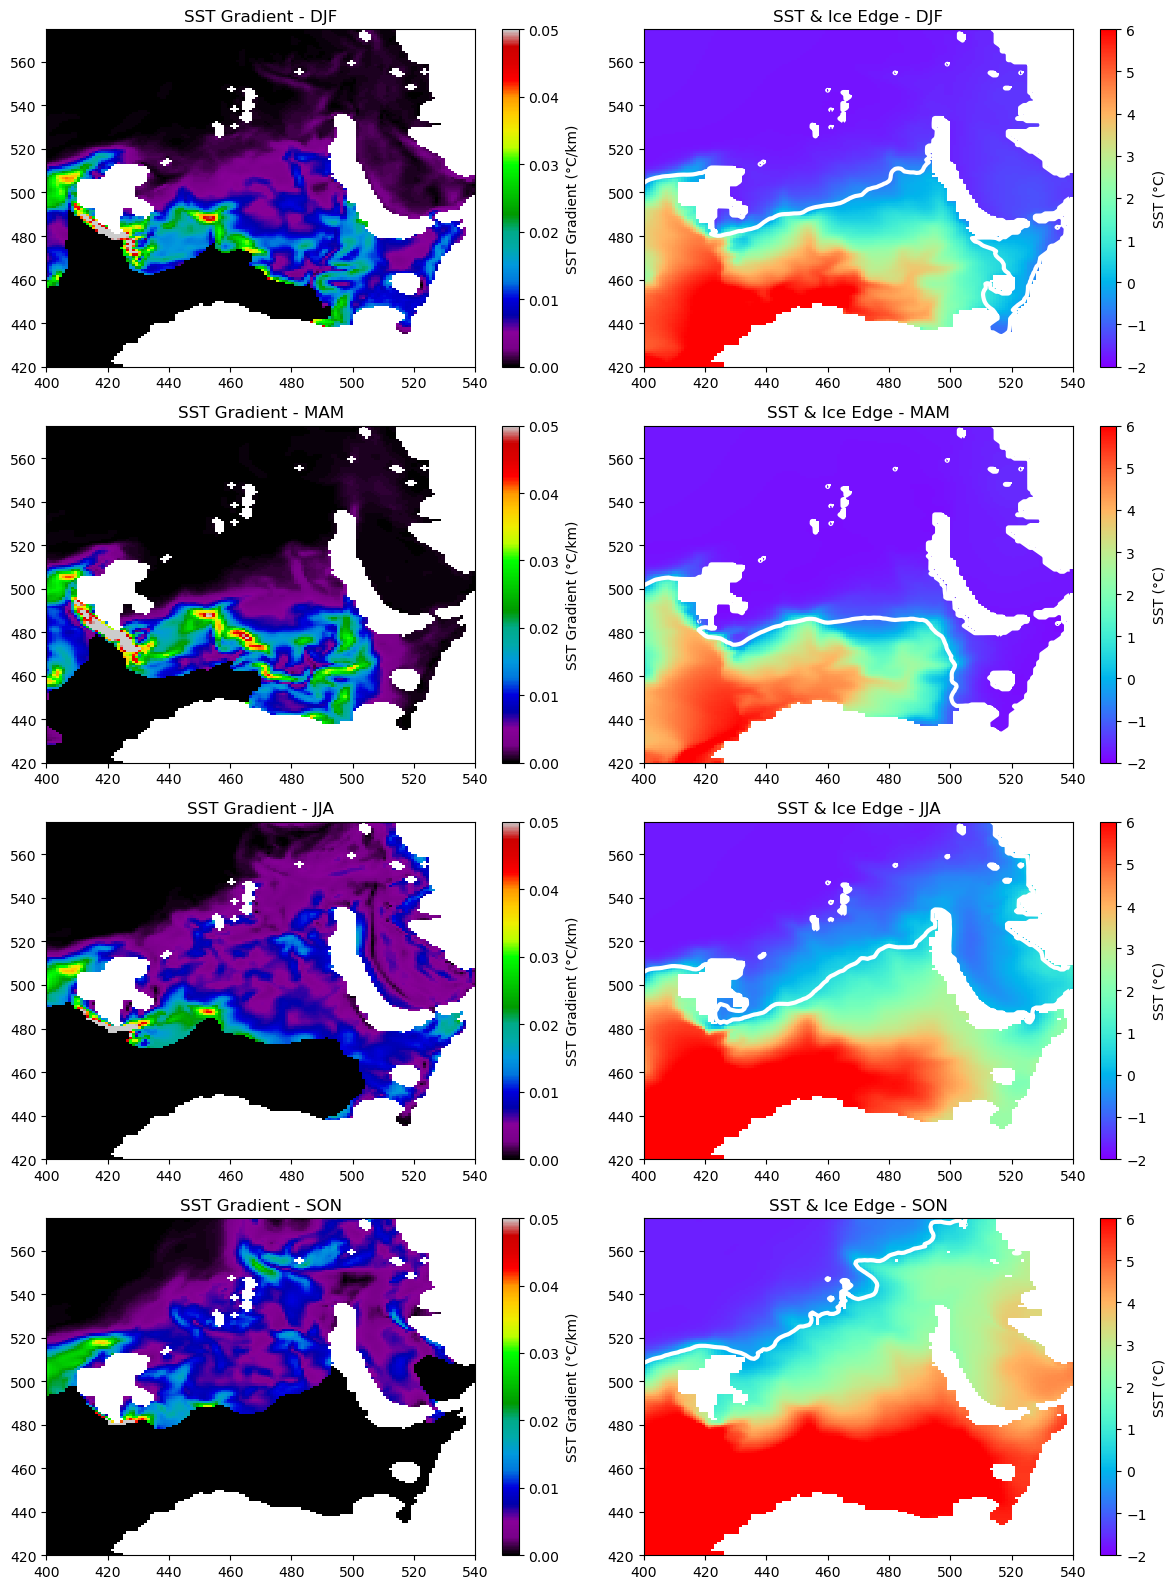

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define seasonal indices
season_indices = {
    "DJF": [11, 0, 1],
    "MAM": [2, 3, 4],
    "JJA": [5, 6, 7],
    "SON": [8, 9, 10]
}

# Compute seasonal averages for SST, Sea Ice, and grad_T
SST_seasonal, SIarea_seasonal, grad_T_seasonal = {}, {}, {}

for season, indices in season_indices.items():
    SST_avg = np.nanmean(np.nanmean(all_SST[2:-1, indices], axis=1), axis=0)
    SIarea_avg = np.nanmean(np.nanmean(all_SIarea[1:-1, indices], axis=1), axis=0)

    # Compute SST gradient (grad_T)
    tracerSST = get_aste_tracer(SST_avg * hfC, nfx, nfy)[0]
    dTdx = np.zeros_like(tracerSST)
    dTdx[:, 1:-1] = (tracerSST[:, 2:] - tracerSST[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])
    dTdy = np.zeros_like(tracerSST)
    dTdy[1:-1, :] = (tracerSST[2:, :] - tracerSST[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])
    grad_T = np.sqrt(dTdx**2 + dTdy**2) * ((tracerSST > -2) & (tracerSST < 4)) * 1000  # Mask and convert to °C/km

    # Store values
    SST_seasonal[season], SIarea_seasonal[season], grad_T_seasonal[season] = SST_avg, SIarea_avg, grad_T

# Create figure with 4x2 subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
season_order = ["DJF", "MAM", "JJA", "SON"]

for i, season in enumerate(season_order):
    # Left column: SST + Sea Ice Edge
    ax = axes[i, 1]
    cb = ax.pcolormesh(get_aste_tracer(SST_seasonal[season], nfx, nfy)[0], vmin=-2, vmax=6, cmap="rainbow")
    ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys")
    ax.contour(get_aste_tracer(SIarea_seasonal[season], nfx, nfy)[0], levels=[0.15], colors="white", linewidths=3)
    plt.colorbar(cb, ax=ax, label="SST (°C)")
    ax.set_xlim(400, 540)
    ax.set_ylim(420, 575)
    ax.set_title(f"SST & Ice Edge - {season}")

    # Right column: SST Gradient
    ax = axes[i, 0]
    cb = ax.pcolormesh(grad_T_seasonal[season], cmap='nipy_spectral', vmin=0, vmax=0.05)
    ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys")
    plt.colorbar(cb, ax=ax, label="SST Gradient (°C/km)")
    ax.set_xlim(400, 540)
    ax.set_ylim(420, 575)
    ax.set_title(f"SST Gradient - {season}")

plt.tight_layout()
# plt.suptitle("2005--2016 SST Gradient and SST")

plt.savefig("figs/Bartonfig2.png",dpi=300)
plt.show()
